In [4]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from matplotlib import pyplot

sns.set()
sns.set(rc={'figure.figsize':(11.7,8.27)})

pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', None) #50 for truncated view, -1 for full view

In [5]:
SWaT_Dataset_Normal_v0 = pd.read_pickle('dataset/SWaT_Dataset_Normal_v0.pkl')
SWaT_Dataset_Normal_v1 = pd.read_pickle('dataset/SWaT_Dataset_Normal_v1.pkl')
SWaT_Dataset_Attack_v0 = pd.read_pickle('dataset/SWaT_Dataset_Attack_v0.pkl')

## Check difference between SWaT_Dataset_Normal_v0 and SWaT_Dataset_Normal_v1

In [6]:
print(len(SWaT_Dataset_Normal_v0))
print(len(SWaT_Dataset_Normal_v1))
print(len(SWaT_Dataset_Attack_v0))

496800
495000
449919


### Check difference between SWaT_Dataset_Normal_v0 and SWaT_Dataset_Normal_v1

In [7]:
d1 = SWaT_Dataset_Normal_v0.iloc[1800:]
d2 = SWaT_Dataset_Normal_v1.iloc[:]

In [8]:
d1 = d1.reset_index(drop=True)
d2 = d2.reset_index(drop=True)

In [9]:
d3 = pd.concat([d1['P1']['FIT101'], d2['P1']['FIT101']], axis=1)

In [10]:
d3['difference'] = d3.apply(lambda x: x[0] - x[1], axis=1)

In [11]:
d3['difference'].sum()

0.0

## Clean dataset

In [12]:
SWaT_Dataset_Attack_v0.columns = SWaT_Dataset_Normal_v0.columns

In [13]:
df = SWaT_Dataset_Normal_v0.append(SWaT_Dataset_Attack_v0)
df = df.reset_index(drop=True)

/tmp/ipykernel_14871/2082133822.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = SWaT_Dataset_Normal_v0.append(SWaT_Dataset_Attack_v0)


Create clean dataset

In [14]:
df = pd.concat([df['Unnamed: 0_level_0'], df['P1'], df['P2'], df['P3'], df['P4'], df['P5'], df['P6']], axis=1)

In [15]:
time_1 = df.iloc[len(df)-1].values[0]
print(time_1)
time_1 = pd.to_datetime(time_1, format='%d/%m/%Y %H:%M:%S %p')
time_1

 2/1/2016 2:59:59 PM


Timestamp('2016-01-02 02:59:59')

In [16]:
time_2 = df.iloc[0].values[0]
print(time_2)
time_2 = pd.to_datetime(time_2, format=' %d/%m/%Y %I:%M:%S %p')
time_2

 22/12/2015 4:00:00 PM


Timestamp('2015-12-22 16:00:00')

Add index column

In [17]:
df['index'] = [i for i in range(len(df))]

Clean Timestamp column

In [18]:
list(df.columns)[0]

' Timestamp'

In [19]:
df.rename(columns={' Timestamp':'Timestamp'}, inplace=True)

In [20]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format=' %d/%m/%Y %I:%M:%S %p')

Clean Normal/Attack column

In [21]:
df['Normal/Attack'].value_counts()

Normal     892098
Attack      54584
A ttack        37
Name: Normal/Attack, dtype: int64

In [22]:
typos = {
    "Attack": ["A ttack"],
}
c = "Normal/Attack"
for expected, founds in typos.items():
    for typo in founds:
        s = df[c] == typo
        df.loc[s, c] = expected

In [23]:
df['Normal/Attack'].value_counts()

Normal    892098
Attack     54621
Name: Normal/Attack, dtype: int64

In [24]:
for col in df.columns:
    if df[col].isna().sum() != 0:
        print(col, df[col].isna().sum())

## Feature Selection

### 1st Method

Check feature with a variance equal to zero

In [ ]:
cols_numeric = list(df.columns)
cols_numeric.remove('Timestamp')
cols_numeric.remove('Normal/Attack')
cols_numeric.remove('index')
for col in cols_numeric:
    var = np.var(df[col])
    if var == 0:
        print(col)
        cols_numeric.remove(col)

remove feature with variance of 0

In [ ]:
#df = df.drop(columns=['P202','P401','P404','P502','P601','P603'])

### 2nd Method : Filter methods

A. Anova feature selection : check variance to verify if there is a significant difference between groups

In [ ]:
cols_numeric = list(df.columns)
cols_numeric.remove('Timestamp')
cols_numeric.remove('index')
data = df[cols_numeric]
X = data.iloc[:, :-1]
y = data.iloc[:,-1]

# https://machinelearningmastery.com/feature-selection-with-numerical-input-data/
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [ ]:

fs = SelectKBest(score_func=f_classif, k='all')
# learn relationship from training data
fs.fit(X_train, y_train)
# transform train input data
X_train_fs = fs.transform(X_train)
# transform test input data
X_test_fs = fs.transform(X_test)


# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()
sum = 0
print(type(fs.scores_[3]))
for i in range(len(fs.scores_)):
	if ((fs.scores_[i])>1.0):
		print(fs.scores_[i])
		sum +=1 
print('Number of features : %d, Numbers of feature with a NOVA score = 0 : %d' % (len(fs.scores_),len(fs.scores_)-sum))
# This features are the same as detected with a variance of 0 above but there are still some very low scores

# print(cols_numeric[31]) P403
# df = df.drop(columns=['P403']) 
print(df['P403'])

B. Information gain : calculates the reduction in entropy from the transformation of a dataset. It can be used for feature selection by evaluating the Information gain of each variable in the context of the target variable.

In [25]:
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
%matplotlib inline

cols_numeric = list(df.columns)
cols_numeric.remove('Timestamp')
cols_numeric.remove('index')
data = df[cols_numeric]
X = data.iloc[:, :-1]
y = data.iloc[:,-1]
# # https://www.analyticsvidhya.com/blog/2020/10/feature-selection-techniques-in-machine-learning/
importances = mutual_info_classif(X,y)
feat_importances = pd.Series(importances, data.columns[0:len(data.columns)-1])
feat_importances.plot(kind='barh',color='teal')
plt.show()

AttributeError: 'DataFrame' object has no attribute 'colmuns'

C. Correlation Coefficient

<AxesSubplot:>

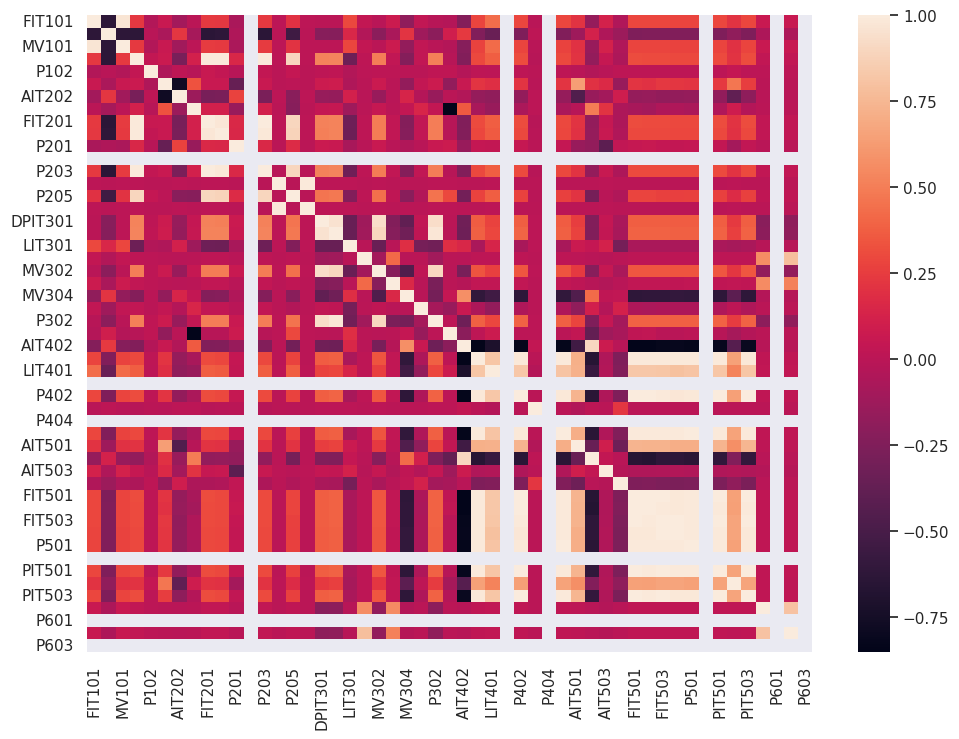

In [30]:
cor = data.corr()
sns.heatmap(cor)

### 3rd method : Wrappers require some method to search the space of all possible subsets of features, assessing their quality by learning and evaluating a classifier with that feature subset

In [ ]:
# https://www.analyticsvidhya.com/blog/2020/10/feature-selection-techniques-in-machine-learning/

## **Normalization of dataset**

In [ ]:
cols_numeric = list(df.columns)
cols_numeric.remove('Timestamp')
cols_numeric.remove('Normal/Attack')
cols_numeric.remove('index')

mean normalization

In [ ]:
data = df[cols_numeric]
mean_normalized_df = (data-data.mean())/data.std()

min-max normalization

In [ ]:
data = df[cols_numeric]
min_max_normalized_df = (data-data.min())/(data.max()-data.min())

## Load list of attacks information

In [ ]:
attacks_list_df = pd.read_csv('attacks_df.csv')

In [ ]:
attacks_list_df['start_time'] = pd.to_datetime(attacks_list_df['start_time'])
attacks_list_df['end_time'] = pd.to_datetime(attacks_list_df['end_time'])
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

delta_time = pd.Timedelta(minutes=0)

df['attack'] = 0
for i in range(len(attacks_list_df)):
    attack_num = attacks_list_df.iloc[i]
    s = df['Timestamp'].between(attack_num['start_time'] - delta_time, attack_num['end_time'] + delta_time)
    df['attack'].loc[s] = attack_num['num_attack']

In [ ]:
df.to_pickle('dataset/clean_dataset.pkl')